In [1]:
import scipy.io
import jax.numpy as np
from scipy.io import loadmat 
import numpy as onp
import matplotlib.pyplot as plt 
import os
import shutil
from PIL import Image
from inrmri.bart import bart_acquisition_from_arrays
from inrmri.data_harvard import get_csmaps_and_mask, get_reference_reco
import pandas as pd
from jax import jit, vmap, random
from inrmri.dip import TimeDependant_DIP_Net, helix_generator, circle_generator
from inrmri.new_radon import ForwardRadonOperator
from inrmri.fourier import fastshiftfourier, get_freqs
from inrmri.basic_nn import weighted_loss 
from inrmri.utils import to_complex, is_inside_of_radial_lim, meshgrid_from_subdiv_autolims, total_variation_batch_complex, save_matrix_and_dict_in_zpy, load_matrix_and_dict_from_zpy    
from inrmri.utils import create_exp_file_name, total_variation_complex
import optax 
from inrmri.metrics_rd import mean_psnr, mean_ssim, mean_artifact_power

In [2]:
from inrmri.utils_rdls import safe_normalize, get_center

In [3]:
def filter_and_get_columns(df, filter_params, target_columns):
    """
    Filters the DataFrame based on filter_params and returns target column values,
    including the original filter parameters in each result dictionary.
    """
    condition = np.ones(len(df), dtype=bool)
    for key, value in filter_params.items():
        condition = condition & (df[key] == value)

    filtered = df.loc[condition, target_columns]
    results = filtered.to_dict(orient='records')

    # Merge each result with the filter parameters
    return [{**filter_params, **res} for res in results]

import numpy as np

def apply_transform(image, dataset_name, volunteer_code, dict_trans):
    """
    Applies flip and rotation to a 30-channel image based on dict_trans.

    Parameters:
    - image: np.ndarray of shape (H, W, 30)
    - dataset_name: str, e.g., 'DATA_1.5T'
    - volunteer_code: str, e.g., 'GC'
    - dict_trans: transformation dictionary

    Returns:
    - transformed image: np.ndarray of shape (H, W, 30)
    """

    if image.shape[-1] != 30:
        raise ValueError("Expected image with 30 channels in the last dimension.")

    trans = dict_trans[dataset_name][volunteer_code]

    # Apply horizontal flip
    if trans['flip_h']:
        image = np.flip(image, axis=1)

    # Apply vertical flip
    if trans['flip_v']:
        image = np.flip(image, axis=0)

    # Apply rotation (must be multiple of 90 degrees)
    rot = trans['rot']
    if rot not in [0, 90, 180, 270]:
        raise ValueError("Rotation must be 0, 90, 180, or 270 degrees.")
    k = rot // 90  # number of 90-degree rotations
    if k:
        # Rotate each channel independently
        image = np.stack([np.rot90(image[..., i], k=k) for i in range(30)], axis=-1)

    return image


## General

In [4]:
total_slices = 8
num_frames   = 30
volunteer    = 'MP'
dataset      = 'DATA_0.55T'
base_path    = '/mnt/workspace/datasets/pulseqCINE/'
# --- PATH ---
base_folder                = base_path + dataset + '/' + volunteer + '/'
train_data_folder          = base_folder + 'traindata/'

In [5]:
stdip_parameters = {
    'experiment_name': 'total_kiter_lambda_denoise_reg', 
    'training_params': {
        'total_kiter':2000,
        'lambda_denoise_reg':1e-7,
        'slice':None,
    }
}

dict_trans = {
    'DATA_1.5T': {
        'GC': {
            'flip_h': False,
            'flip_v': False,
            'rot': 0,
        },
        'CM': {
            'flip_h': False,
            'flip_v': False,
            'rot': 0,
        },
        'DW': {
            'flip_h': False,
            'flip_v': False,
            'rot': 0,
        },
    },
    'DATA_0.55T': {
        'MP': {
            'flip_h': True,
            'flip_v': True,
            'rot': 0,
        },
        'FH': {
            'flip_h': True,
            'flip_v': True,
            'rot': 0,
        }, 
        'TC': {
            'flip_h': True,
            'flip_v': True,
            'rot': 0,
        }, 
    }
}

In [6]:
target_columns = ['training_name', 'psnr', 'ssim', 'it', 'duration [min]', 'duration [s]']

In [7]:
multi_bh_slices_list   = []
single_bh_slices_list  = []

for slice_num in [1,2,3,4,5,6,7,8]:
    stdip_parameters['training_params']['slice'] = slice_num
    # dataset
    dataset_name          = 'slice_' + str(slice_num) + '_' + str(total_slices) +'_nbins' + str(num_frames)
    path_dataset          = train_data_folder + dataset_name + '.npz'
    # multi breathold
    data         = onp.load(path_dataset)
    recon_fs     = data["recon_fs"]
    recon_fs       = get_center(recon_fs) 
    recon_fs = apply_transform(recon_fs, dataset, volunteer, dict_trans)
    recon_fs       = safe_normalize(recon_fs)
    multi_bh_slices_list.append(   recon_fs    )
    # single breathold
    stdip_parameters['path']               =   base_folder + 'stDIP'
    stdip_parameters['csv_path']           =   stdip_parameters['path'] +  '/' + stdip_parameters['experiment_name'] + ".csv"
    stdip_parameters['csv_path_summary']   =   stdip_parameters['path'] +  '/' + stdip_parameters['experiment_name'] + "_summary.csv"
    stdip_parameters['exp_folder_path']    =   stdip_parameters['path'] +  '/' + dataset_name + '/' + stdip_parameters['experiment_name']
    df_stdip                               =   pd.read_csv(stdip_parameters['csv_path'] , delimiter=';')
    stDIP_results                          =   filter_and_get_columns(df_stdip, stdip_parameters['training_params'], target_columns)[0]
    stdip_parameters['best_recon_path']    =   stdip_parameters['exp_folder_path'] +  '/' + stDIP_results['training_name'] + '/' + 'best_recon.npz'
    stDIP_results['recon']                 =   onp.load(stdip_parameters['best_recon_path'], allow_pickle=True)['best_recon']
    stDIP_results['recon']                 =   apply_transform(stDIP_results['recon'], dataset, volunteer, dict_trans)
    stDIP_results['recon']                 =   safe_normalize(stDIP_results['recon']) 
    single_bh_slices_list.append(   stDIP_results['recon']    )

2025-06-17 16:04:53.365216: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [8]:
multi_bh_slices_array = np.stack(multi_bh_slices_list, axis=0)
single_bh_slices_array = np.stack(single_bh_slices_list, axis=0)
multi_bh_slices_array.shape , single_bh_slices_array.shape

((8, 128, 128, 30), (8, 128, 128, 30))

## Try to do the long axis plot

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates

def extract_angled_line_numpy(img, center, angle_deg, length):
    angle_rad = np.deg2rad(angle_deg)
    dx = (length / 2) * np.cos(angle_rad)
    dy = (length / 2) * np.sin(angle_rad)

    x_vals = np.linspace(center[1] - dx, center[1] + dx, int(length))
    y_vals = np.linspace(center[0] - dy, center[0] + dy, int(length))

    line = map_coordinates(img, [y_vals, x_vals], order=1, mode='constant')
    return line, (x_vals, y_vals)

def extract_synthetic_long_axis(cine_data, frame=0, angle_deg=90, length=100, center_offset=(0, 0)):
    n_slices, X, Y, _ = cine_data.shape
    cy = X // 2 + center_offset[0]
    cx = Y // 2 + center_offset[1]
    center = (cy, cx)

    synthetic_image = []
    for s in range(n_slices):
        img = cine_data[s, :, :, frame]
        line, _ = extract_angled_line_numpy(img, center, angle_deg, length)
        synthetic_image.append(line)

    return np.array(synthetic_image)  # shape: (n_slices, length)

def plot_all_slices_with_line_and_long_axis(cine_data, frame=0, angle_deg=90, length=100, center_offset=(0, 0)):
    n_slices, X, Y, _ = cine_data.shape
    cy = X // 2 + center_offset[0]
    cx = Y // 2 + center_offset[1]
    center = (cy, cx)

    # Get synthetic long-axis image
    long_axis_img = extract_synthetic_long_axis(cine_data, frame, angle_deg, length, center_offset)

    # Coordinates for overlay line
    angle_rad = np.deg2rad(angle_deg)
    dx = (length / 2) * np.cos(angle_rad)
    dy = (length / 2) * np.sin(angle_rad)
    x_vals = np.linspace(cx - dx, cx + dx, int(length))
    y_vals = np.linspace(cy - dy, cy + dy, int(length))

    # Plot all slices with the line
    cols = 5
    rows = int(np.ceil(n_slices / cols))
    plt.figure(figsize=(3 * cols, 3 * rows))

    for s in range(n_slices):
        img = cine_data[s, :, :, frame]
        plt.subplot(rows, cols, s + 1)
        plt.imshow(img, cmap='gray')
        plt.plot(x_vals, y_vals, 'r-', linewidth=1)
        plt.title(f"Slice {s}")
        plt.axis('off')

    plt.suptitle(f"Frame {frame} | Line Angle {angle_deg}°, Offset {center_offset}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Plot synthetic long-axis image
    plt.figure(figsize=(10, 4))
    plt.imshow(long_axis_img, cmap='bone', aspect='auto')
    plt.title("Synthetic Long-Axis View")
    plt.xlabel("Line pixels")
    plt.ylabel("Slice index")
    plt.show()


In [27]:
multi_bh_slices_array.shape,  single_bh_slices_array.shape

((8, 128, 128, 30), (8, 128, 128, 30))

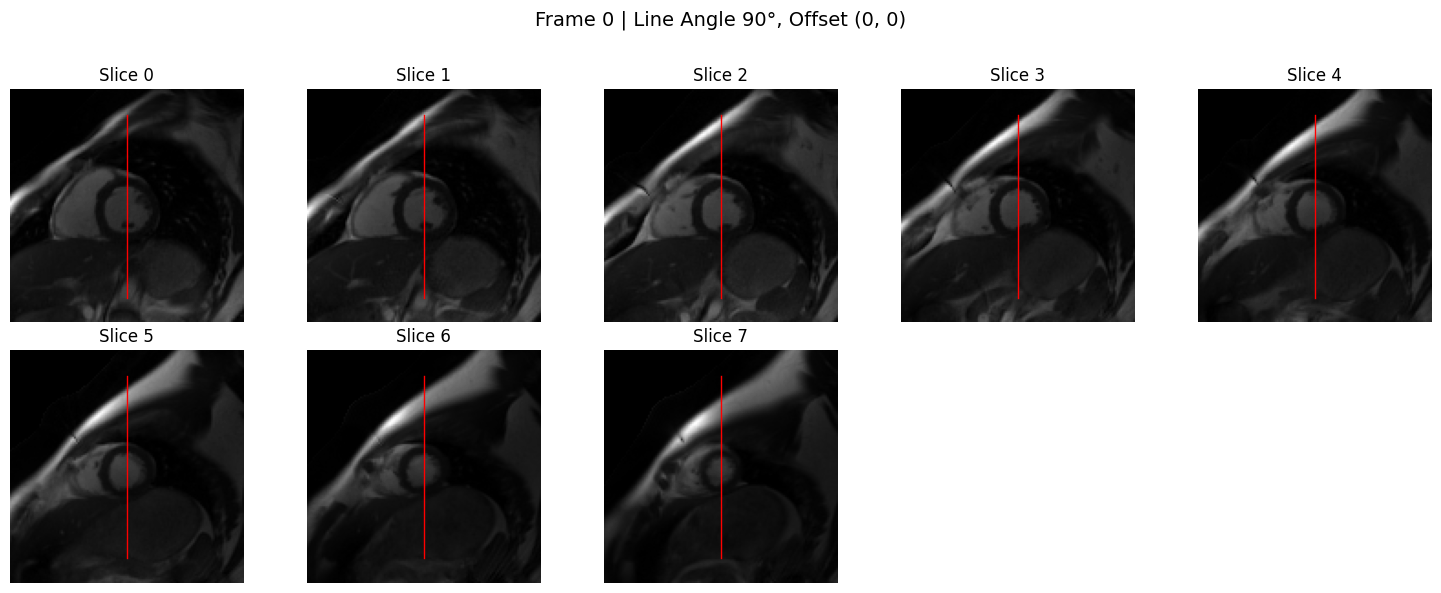

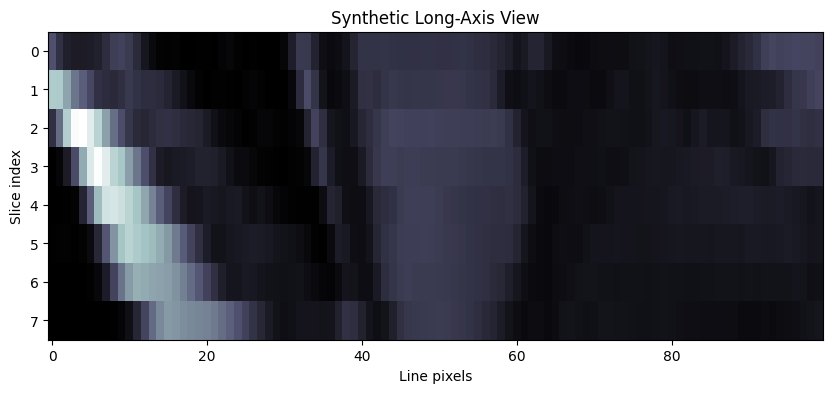

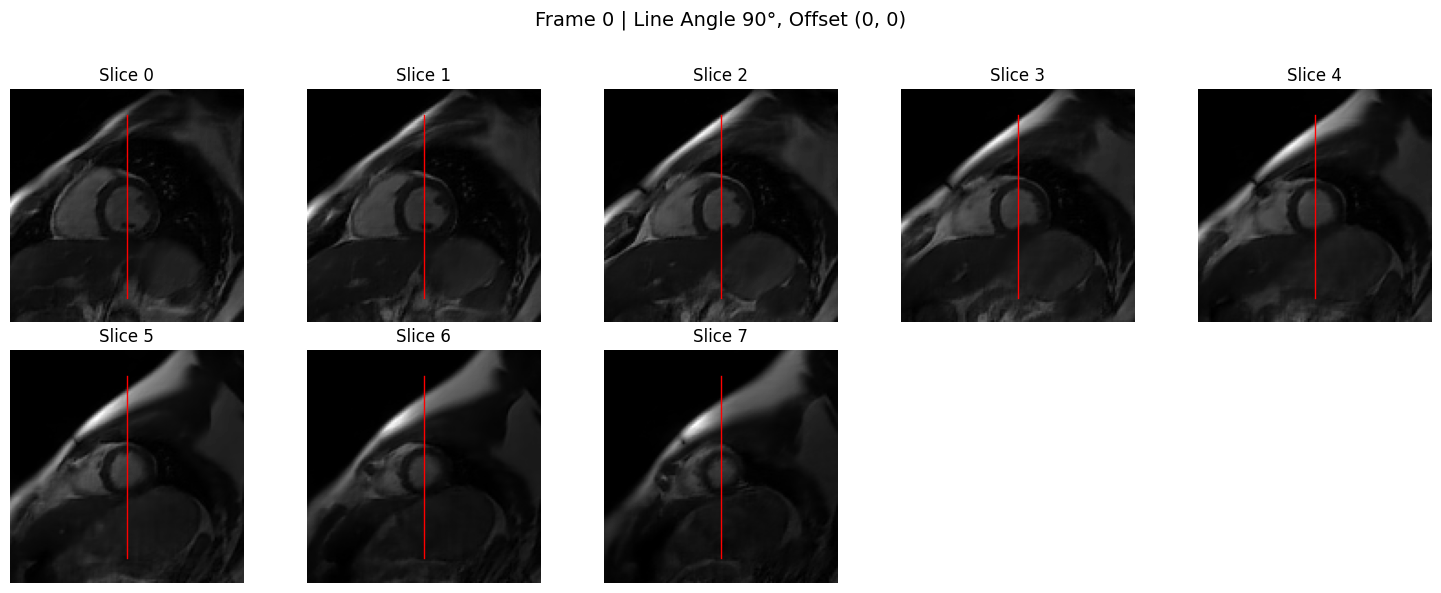

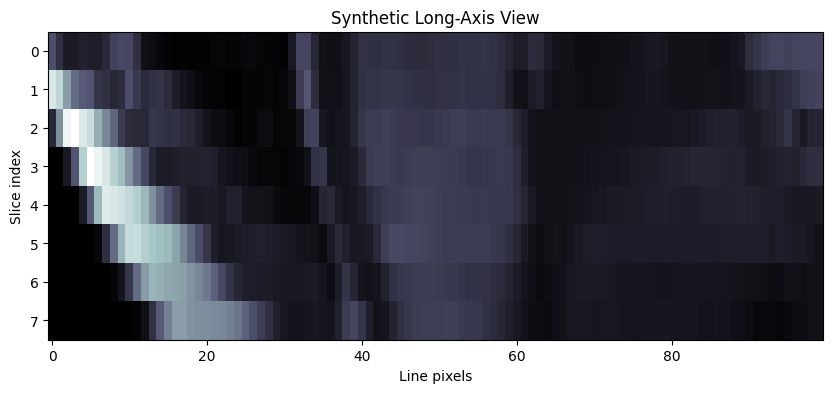

In [28]:
plot_all_slices_with_line_and_long_axis(multi_bh_slices_array, frame=0, angle_deg=90, length=100, center_offset=(0, 0))
plot_all_slices_with_line_and_long_axis(single_bh_slices_array, frame=0, angle_deg=90, length=100, center_offset=(0, 0))